Import

In [ ]:
print("Importing")
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import accuracy_score
import argparse
import time
import math
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
import os
import pickle
from PIL import Image
from torch.utils.data import Dataset, DataLoader

Importing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DLProject1')

Mounted at /content/drive


Data and transformations

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

normform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])])
train= torchvision.datasets.CIFAR10('./CIFAR10', train=True, download=True, transform=transform)
# testorig = torchvision.datasets.CIFAR10('./CIFAR10', train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
test = torchvision.datasets.CIFAR10('./CIFAR10', train=False, download=True, transform=normform)

# train_size = int(0.8 * len(trainall)) # 80% for training
# val_size = len(trainall) - train_size # Remaining 20% for validation
# train, val = torch.utils.data.random_split(trainall, [train_size, val_size])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainDataLoader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=4)
testDataLoader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False, num_workers=4)
# origDataLoader = torch.utils.data.DataLoader(testorig, batch_size=128, shuffle=False, num_workers=4)

Kaggle test data

In [ ]:
normform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])])
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
ftest = load_cifar_batch('cifar_test_nolabel.pkl')

# Extract images
images = ftest[b'data']
ids = ftest[b'ids']

class ImageDataset(Dataset):
    def __init__(self, image_array, ids, transform=None):
        self.image_array = image_array
        self.transform = transform
        self.ids = ids
    def __len__(self):
        return len(self.image_array)

    def __getitem__(self, idx):
        image = Image.fromarray(self.image_array[idx])
        id = self.ids[idx]
        if self.transform:
            image = self.transform(image)
        return image,id

ftestdataset = ImageDataset(images, ids, transform=normform)
ftestDataLoader = DataLoader(ftestdataset, batch_size=128, shuffle=False)

Model

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth=34, num_classes=10, widen_factor=3, dropRate=0.4):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

Parameters and optimizer

In [ ]:
depth = 34
width_factor = 3
droprate = 0.4
model = WideResNet(depth=depth, widen_factor=width_factor, dropRate=droprate).cuda()
loss = torch.nn.CrossEntropyLoss()
epochs = 100
optimizer = None
opt = 'sgdwn'
match opt: #C6
  case 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
  case 'sgdwn':
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-3, nesterov=True)
  case 'adagrad':
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0, weight_decay=5e-4, initial_accumulator_value=0, eps=1e-10)
  case 'adadelta':
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, rho=0.9, eps=1e-06, weight_decay=5e-4)
  case 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4)
  case 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4)

scheduler = MultiStepLR(optimizer, milestones=[20,30,40,50,60,65,70,75,80,85,90,95], gamma=0.3)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

Param count

In [ ]:
def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))
testmodel = WideResNet()
test(testmodel)


Total number of params 4166298
Total layers 35


Training loop + Load model

In [ ]:
state_dict = torch.load('WideRes/d28w3sgdwnmallmodel_weights.pth')
model.load_state_dict(state_dict)

<ipython-input-7-8bb992c91775>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('WideRes/d28w3sgdwnmallmodel_weights.pth')


<All keys matched successfully>

In [ ]:
print("Training ...")
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(epochs):
  train_loss = val_loss = 0.0
  predictions = np.empty(0)
  groundtruth = np.empty(0)
  valpredictions = np.empty(0)
  valgroundtruth = np.empty(0)

  # train
  model.train()
  trainiter = iter(trainDataLoader)
  for i in range(len(trainDataLoader)):

    images, labels = next(trainiter)

    #Move to device
    images = images.cuda()
    labels = labels.cuda()

    optimizer.zero_grad()
    outputs = model(images) #forward
    fit = loss(outputs, labels) #calculate loss
    fit.backward() #backprop
    optimizer.step() #update weights
    train_loss += fit.item()

    predlabels = torch.max(outputs, dim=1)[1]
    predictions = np.append(predictions, predlabels.cpu().detach().numpy())
    groundtruth = np.append(groundtruth, labels.cpu().detach().numpy())
  scheduler.step() #LR

  # validation
  model.eval()
  valiter = iter(testDataLoader)
  for i in range(len(testDataLoader)):
    with torch.no_grad():

      images, labels = next(valiter)

      #Move to device
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images) #forward
      fit = loss(outputs, labels) #calculate loss
      val_loss += fit.item()

      predlabels = torch.max(outputs, dim=1)[1]
      valpredictions = np.append(valpredictions, predlabels.cpu().detach().numpy())
      valgroundtruth = np.append(valgroundtruth, labels.cpu().detach().numpy())
  train_loss = train_loss/len(trainDataLoader)
  val_loss = val_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  val_loss_history.append(val_loss)
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, val_loss))

  train_acc_history.append(accuracy_score(predictions, groundtruth))
  val_acc_history.append(accuracy_score(valpredictions, valgroundtruth))

print('Best Training Accuracy: {:.6f}\n'.format(max(train_acc_history)))
print('Best Validation Accuracy: {:.6f}\n'.format(max(val_acc_history)))

#save model
torch.save(model.state_dict(), 'WideRes/d34w3sgdwnsmallmodel_weights.pth')

Training ...
Epoch: 1 	Training Loss: 1.900013 	Validation Loss: 2.802761
Epoch: 2 	Training Loss: 1.553443 	Validation Loss: 1.636399
Epoch: 3 	Training Loss: 1.265645 	Validation Loss: 1.346302
Epoch: 4 	Training Loss: 1.095651 	Validation Loss: 1.165082
Epoch: 5 	Training Loss: 0.989288 	Validation Loss: 1.088321
Epoch: 6 	Training Loss: 0.905842 	Validation Loss: 0.984243
Epoch: 7 	Training Loss: 0.828518 	Validation Loss: 0.798061
Epoch: 8 	Training Loss: 0.756602 	Validation Loss: 0.788947
Epoch: 9 	Training Loss: 0.709118 	Validation Loss: 0.889937
Epoch: 10 	Training Loss: 0.669741 	Validation Loss: 0.778383
Epoch: 11 	Training Loss: 0.648387 	Validation Loss: 0.628940
Epoch: 12 	Training Loss: 0.626190 	Validation Loss: 0.582549
Epoch: 13 	Training Loss: 0.608712 	Validation Loss: 0.719991
Epoch: 14 	Training Loss: 0.593438 	Validation Loss: 0.628991
Epoch: 15 	Training Loss: 0.577969 	Validation Loss: 0.733700
Epoch: 16 	Training Loss: 0.570970 	Validation Loss: 0.632779
Epoc

Plots

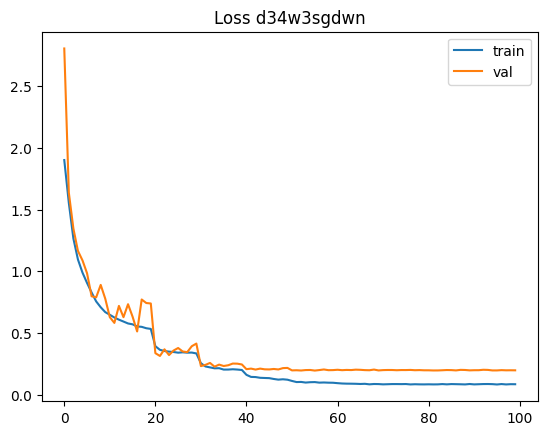

In [ ]:
name = "d34w3sgdwn"
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.title('Loss '+name)
plt.legend()
plt.show()

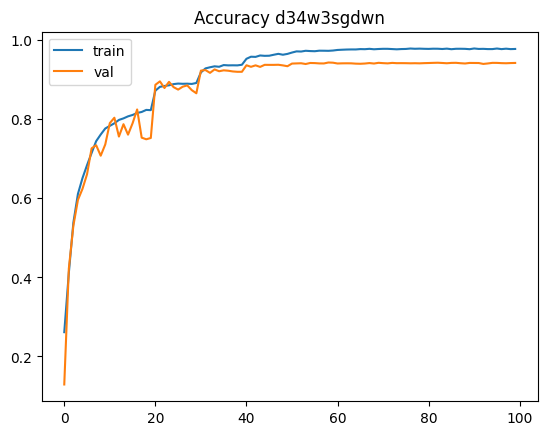

In [ ]:
plt.plot(train_acc_history, label='train')
plt.plot(val_acc_history, label='val')
plt.title('Accuracy '+name)
plt.legend()
plt.show()

In [ ]:
# #test
# testiter = iter(testDataLoader)
# testpredictions = np.empty(0)
# testgroundtruth = np.empty(0)
# for i in range(len(testDataLoader)):
#     with torch.no_grad():
#       images, labels = next(testiter)

#       #Move to device
#       images = images.cuda()
#       labels = labels.cuda()

#       outputs = model(images) #forward
#       fit = loss(outputs, labels) #calculate loss
#       test_loss = fit.item()

#       predlabels = torch.max(outputs, dim=1)[1]
#       testpredictions = np.append(testpredictions, predlabels.cpu().detach().numpy())
#       testgroundtruth = np.append(testgroundtruth, labels.cpu().detach().numpy())
# test_acc = accuracy_score(testpredictions, testgroundtruth)
# print('Final Test Accuracy: {:.6f}\n'.format(test_acc))

Kaggle test output

In [ ]:
#final test
ftestiter = iter(ftestDataLoader)
ftestpredictions = np.empty(0)
ftestids = np.empty(0)
for i in range(len(ftestDataLoader)):
    with torch.no_grad():
      images, ids = next(ftestiter)

      #Move to device
      images = images.cuda()

      outputs = model(images) #forward

      predlabels = torch.max(outputs, dim=1)[1]
      ftestpredictions = np.append(ftestpredictions, predlabels.cpu().detach().numpy())
      ftestids = np.append(ftestids, ids)
ftestpredictions = ftestpredictions.astype(int)
ftestids = ftestids.astype(int)
outarr = np.column_stack((ftestids, ftestpredictions)).astype(int)

header_string = "ID,Labels"

# Save the array to a CSV file with headers
np.savetxt("out.csv", outarr, delimiter=",", header=header_string, fmt='%d', comments = "")